Web scraping indeed website for data science jobs based on Greg Reda's [excellent tutorial](http://www.gregreda.com/2013/03/03/web-scraping-101-with-python/) and Jesse Steinweg's [excellent analysis](https://jessesw.com/Data-Science-Skills/) and finally, Sung Pil Moon's [awesome analysis](http://blog.nycdatascience.com/students-work/project-3-web-scraping-company-data-from-indeed-com-and-dice-com/)

## 1) Admin and Setup

I've already created a virtual environment in conda by downloading bs4. Please feel free to use my environment.yaml to create a similar virtual env. I'll update it as I go.

In [1]:
from bs4 import BeautifulSoup
from urllib2 import urlopen
import pandas as pd
import re
import numpy as np
from time import sleep
%matplotlib inline
import pylab as plt
import os

## 2) What do I want to achieve

http://au.indeed.com/jobs?as_and=&as_phr=&as_any=%22customer+analytics%22+%22data+analysis%22&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=&radius=50&l=&fromage=any&limit=10&sort=&psf=advsrch

OR

http://au.indeed.com/jobs?as_and=&as_phr=&as_any=%22customer+analytics%22+%22data+analysis%22&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=&radius=0&l=Sydney+NSW&fromage=last&limit=10&sort=&psf=advsrch

in a nice tabular format for data exploration

## 3) Create a function for data collection

In [2]:
def get_data_job_board(job_query1,job_query2,job_query3):
    #STEP1
    # create query string in the required format
    # 1) within search string, spaces are replaced by '+' in html
    # 2) each search query is preceded and succeeded by a "%22"
    # 3) string the elements of the list into one string separated by a "+"
    job_query_string = []
    job_query_string.append("%22" + job_query1.replace(" ","+") + "%22")
    job_query_string.append("%22" + job_query2.replace(" ","+") + "%22")
    job_query_string.append("%22" + job_query3.replace(" ","+") + "%22")
    job_query_string = "+".join(job_query_string)
    
    stepname = 'one'
    
    #STEP2
    # start of the url - this will not change because I'm including search query to search
    # anywhere in the job ad. Not just the job title.
    base_url = 'http://au.indeed.com/jobs?as_and=&as_phr=&as_any='
    
    stepname = 'two'
    
    #STEP3
    #company name, salary, location and fromage are not being worked on currently
    #pagenum is null for the first time the query is generated
    company_name_string=''
    salary_string=''
    location_string=''
    fromage_string='any'
    
    stepname = 'three'
    
    #STEP4
    #create query to read the page for the first time
    initial_query = [base_url,job_query_string,'&as_not=&as_ttl=&as_cmp=',company_name_string,
                '&jt=all&st=&salary=',salary_string,'&radius=50&l=',location_string,
                '&fromage=',fromage_string,'&limit=10&sort=&']
    initial_query = "".join(initial_query)
    
    stepname = 'four'
    
    #open website and read it
    try:
        html = urlopen(initial_query).read()  
        soup = BeautifulSoup(html, "lxml")
        
        stepname = 'five'
    
        #find how many times to loop through to get each job
        number_of_jobs_page_area = soup.find(id="searchCount").string.encode('utf-8')
        number_of_jobs = re.findall('\d+', number_of_jobs_page_area.replace(',',''))
        total_number_of_jobs = int(number_of_jobs[2])
        number_of_pages_to_scroll = np.ceil(total_number_of_jobs/10)
        
        print total_number_of_jobs,' jobs found for search terms:',job_query1.upper(), \
                                                    ',',job_query2.upper(),',',job_query3.upper()
        
        if total_number_of_jobs > 1000: #realised that job board has limitation to show only 1000 records
            print 'Limiting Search to first 1000 records...'
        
        stepname = 'six'
            
        #initialise variables for storing page variables
        jobtitle = []
        companyname = []
        location = []
        advertised_number_of_days_ago = []
        company_rating = []
        company_rating_counts = []
        salary = []
        summary = []
        joblink = []
        previous_job_number_start = '' # this will be used to determine when to break loop 
                                       # (indeed repeats job postings)       
        
        #loop through
        for counter in xrange(0,100):
         
            stepname = 'seven'
            
            #create query to read the page
            sleep(1)   #giving it a one second buffer because we don't want to overload server
            page_query = [base_url,job_query_string,'&as_not=&as_ttl=&as_cmp=',company_name_string,
                   '&jt=all&st=&salary=',salary_string,'&radius=50&l=',location_string,
                   '&fromage=',fromage_string,'&limit=10&sort=&start=',str(counter * 10)]
            page_query = "".join(page_query)
            
            stepname = 'eight'
            
            #read page contents
            html = urlopen(page_query).read()  
            soup = BeautifulSoup(html, "lxml")
            
            #print page numbers for each page fetch
            current_page_number_of_jobs_page_area = soup.find(id="searchCount").string.encode('utf-8')
            current_page_number_of_jobs = re.findall('\d+', current_page_number_of_jobs_page_area.replace(',',''))
            
            #this test is to not repeat job fetches. indeed removes the last couple of hundred job postings
            #because they are similar to what has been previously displayed. We remove it from our fetch too
            if int(current_page_number_of_jobs[0]) == previous_job_number_start:
                break
            previous_job_number_start = int(current_page_number_of_jobs[0])
            
            print 'Fetching details for jobs', int(current_page_number_of_jobs[0]), \
            'to',int(current_page_number_of_jobs[1])
            
            #extract page body / details into a BS4 element result set called targetElements
            targetElements = soup.findAll('div', attrs = {'class' : ' row result'})
            targetElements.extend(soup.findAll('div', attrs = {'class' : 'lastRow row result'}))
            
            #start storing into variable lists
            for elem in targetElements:
                
                #job title
                jobtitle.append(elem.find('a', attrs = {'class':'turnstileLink'}).attrs['title'])              
                
                #company name
                if elem.find('span', attrs = {'itemprop':'name'}) is None:
                    companyname.append(None)
                else:
                    companyname.append(elem.find('span', attrs = {'itemprop':'name'})
                                     .getText().strip().encode('utf-8'))  
                
                #location
                location.append(elem.find('span', attrs = {'itemprop':'addressLocality'})
                                .getText().strip().encode('utf-8'))
                
                #summary
                summary.append(elem.find('span', attrs = {'class':'summary'})
                               .getText().strip().encode('utf-8'))
                
                #company rating
                if elem.find('span', attrs = [{'class':'ratingNumber'}]) is None:
                    company_rating.append(None)
                else:
                    company_rating.append(elem.find('span', attrs = {'class':'ratingNumber'})
                                     .getText().strip().encode('utf-8'))
                
                #company rating counts
                if elem.find('span', attrs = {'class':'slNoUnderline'}) is None:
                    company_rating_counts.append(None)
                else:
                    company_rating_counts.append(elem.find('span', attrs = {'class':'slNoUnderline'})
                                     .getText().strip().encode('utf-8'))
                
                #advertised number of days ago
                if elem.find('span', attrs = {'class':'date'}) is None:
                    advertised_number_of_days_ago.append(None)
                else:
                    advertised_number_of_days_ago.append(elem.find('span', attrs = {'class':'date'})
                                     .getText().strip().encode('utf-8'))
                    
                #salary
                if elem.find('nobr') is None:
                    salary.append(None)
                else:
                    salary.append(elem.find('nobr').getText().strip().encode('utf-8'))
                
                #job link
                home_url = 'http://www.indeed.com'
                joblink.append("%s%s" % (home_url,elem.find('a').get('href')))
                
        #after all pages are extracted, store them into a dataframe
        df_columns=['query_date','jobtitle','companyname','location',
                 'advertised_number_of_days_ago','company_rating',
                 'company_rating_counts','salary','summary',
                 'joblink','job_query_string']

        df_joblist = pd.DataFrame({'query_date':pd.to_datetime('today'),
                                'jobtitle':jobtitle,
                                'companyname':companyname,
                                'location':location,
                                'advertised_number_of_days_ago':advertised_number_of_days_ago,
                                'company_rating':company_rating,
                                'company_rating_counts':company_rating_counts,
                                'salary':salary,
                                'summary':summary,
                                'joblink':joblink,
                                'job_query_string':job_query_string},
                                 columns = df_columns)
            
        return df_joblist    

    except:
        print 'something went wrong...'
        return

In [3]:
#df_joblist = get_data_job_board('data scientist','customer analytics','data analysis')
df_joblist = get_data_job_board('customer analytics','data scientist','data analysis')

927  jobs found for search terms: CUSTOMER ANALYTICS , DATA SCIENTIST , DATA ANALYSIS
Fetching details for jobs 1 to 10
Fetching details for jobs 11 to 20
Fetching details for jobs 21 to 30
Fetching details for jobs 31 to 40
Fetching details for jobs 41 to 50
Fetching details for jobs 51 to 60
Fetching details for jobs 61 to 70
Fetching details for jobs 71 to 80
Fetching details for jobs 81 to 90
Fetching details for jobs 91 to 100
Fetching details for jobs 101 to 110
Fetching details for jobs 111 to 120
Fetching details for jobs 121 to 130
Fetching details for jobs 131 to 140
Fetching details for jobs 141 to 150
Fetching details for jobs 151 to 160
Fetching details for jobs 161 to 170
Fetching details for jobs 171 to 180
Fetching details for jobs 181 to 190
Fetching details for jobs 191 to 200
Fetching details for jobs 201 to 210
Fetching details for jobs 211 to 220
Fetching details for jobs 221 to 230
Fetching details for jobs 231 to 240
Fetching details for jobs 241 to 250
Fetching 

## Check job dataset

In [4]:
len(df_joblist)

811

In [5]:
df_joblist.head(3)

,query_date,jobtitle,companyname,location,advertised_number_of_days_ago,company_rating,company_rating_counts,salary,summary,joblink,job_query_string
0,2016-06-20,Business Intelligence,Telstra Super Pty Ltd,Australia,5 days ago,None,None,None,"Delivering enterprise information management, ...",http://www.indeed.com/rc/clk?jk=ae3702bc44032e...,%22customer+analytics%22+%22data+scientist%22+...
1,2016-06-20,Business Intelligence Analyst,Macquarie Group Limited,Sydney NSW,19 days ago,None,17 reviews,None,Data visualisation and analysis of large data ...,http://www.indeed.com/rc/clk?jk=d0b72c272713c8...,%22customer+analytics%22+%22data+scientist%22+...
2,2016-06-20,Business Intelligence Analyst,Trimble Navigation Limited,Remote,30+ days ago,None,45 reviews,None,Data models and data Architecture. Understandi...,http://www.indeed.com/rc/clk?jk=beea171fc08afa...,%22customer+analytics%22+%22data+scientist%22+...


## 4) Little bit of data wrangling

#### Create derived field for advertised_date

In [6]:
df_joblist.advertised_number_of_days_ago.sort_values().unique()

array(['1 day ago', '1 hour ago', '10 days ago', '10 hours ago',
       '11 days ago', '11 hours ago', '12 days ago', '13 days ago',
       '14 days ago', '15 days ago', '16 days ago', '17 days ago',
       '18 days ago', '18 hours ago', '19 days ago', '2 days ago',
       '2 hours ago', '20 days ago', '21 days ago', '22 days ago',
       '23 days ago', '23 hours ago', '24 days ago', '25 days ago',
       '26 days ago', '27 days ago', '27 minutes ago', '28 days ago',
       '29 days ago', '3 days ago', '3 hours ago', '30 days ago',
       '30+ days ago', '31 minutes ago', '4 days ago', '5 days ago',
       '6 days ago', '6 hours ago', '7 days ago', '7 hours ago',
       '8 days ago', '9 days ago', '9 hours ago'], dtype=object)

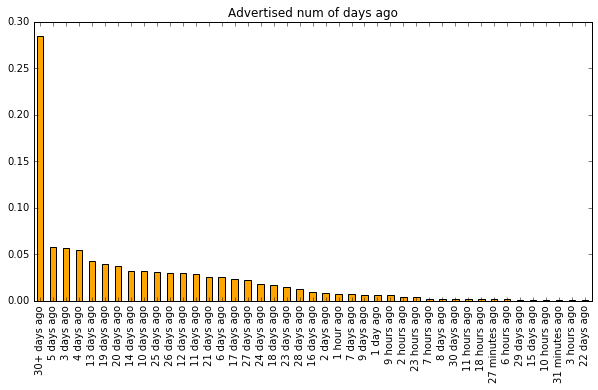

In [8]:
plt.rc('figure', figsize=(10, 5))
df_joblist.advertised_number_of_days_ago.value_counts(normalize=True).plot(kind='bar',
                                  title="Advertised num of days ago",
                                  color='orange',
                                  align='center')

In [10]:
def compute_advertised_date(row):
    #extract number and identifier (days or hours)
    
    advertised_number = int(re.findall('\d+', row['advertised_number_of_days_ago'])[0])
    
    if re.findall('hour', row['advertised_number_of_days_ago']):
        return row['query_date']
    elif re.findall('day', row['advertised_number_of_days_ago']) and advertised_number == 30:
        return row['query_date'] - pd.Timedelta(days=30) #jobs advertised 30+ days ago also defaulted to 30 days.
    elif re.findall('day', row['advertised_number_of_days_ago']) and advertised_number != 30:            
        return row['query_date'] - pd.Timedelta(days=advertised_number)
    else:
        return None

In [11]:
# apply to the dataframe
df_joblist['advertised_date'] = df_joblist.apply (lambda row: compute_advertised_date(row),axis=1)

#### Reading from the pre-existing csv file

In [34]:
indeed_job_board_listing = pd.read_csv('indeed_job_board_listing.csv', encoding='utf-8')
indeed_job_board_listing.head(2)

,query_date,jobtitle,companyname,location,advertised_number_of_days_ago,company_rating,company_rating_counts,salary,summary,joblink,job_query_string,advertised_date
0,2016-06-20,Business Intelligence,Telstra Super Pty Ltd,Australia,5 days ago,NaN,NaN,NaN,"Delivering enterprise information management, ...",http://www.indeed.com/rc/clk?jk=ae3702bc44032e...,%22customer+analytics%22+%22data+scientist%22+...,2016-06-15
1,2016-06-20,Business Intelligence Analyst,Macquarie Group Limited,Sydney NSW,19 days ago,NaN,17 reviews,NaN,Data visualisation and analysis of large data ...,http://www.indeed.com/rc/clk?jk=d0b72c272713c8...,%22customer+analytics%22+%22data+scientist%22+...,2016-06-01


In [24]:
len(indeed_job_board_listing)

811

#### Write to CSV file

In [28]:
#append df_joblist to existing job board listing dataframe
indeed_job_board_listing = indeed_job_board_listing.append(df_joblist)

In [29]:
len(indeed_job_board_listing)

1622

In [30]:
indeed_job_board_listing_deduped = indeed_job_board_listing.duplicated(keep = 'first')
print len(indeed_job_board_listing_deduped)

1622


/Users/Vivek/anaconda/envs/web_scraping/lib/python2.7/site-packages/pandas/core/algorithms.py:185: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  labels = table.get_labels(vals, uniques, 0, na_sentinel, True)


In [22]:
#writing to a tab delimited csv
df_joblist.to_csv('indeed_job_board_listing.csv', index = False, encoding='utf-8')

For some reason, the unicode issue is causing the new df_joblist to look different from the read csv file. So my plan is to append the df_joblist data into csv without header..

Then the plan is to read the whole file as a whole, and finally weed out the duplicates and re-write the whole file into csv afresh. i know it's roundabout, but can't think of any other way at the moment.

In [ ]:
# if file does not exist write header 
if not os.path.isfile('indeed_job_board_listing.csv'):
   df_joblist.to_csv('indeed_job_board_listing.csv',index = False, encoding='utf-8')
else: # else it exists so append without writing the header
    df_joblist.to_csv('indeed_job_board_listing.csv',mode = 'a',header=False, index = False, encoding='utf-8')